In [2]:
import pandas as pd
import numpy as np


umbrales = {
    'RS':0.2, 
    'P':2000000, 
    'RSA':0.1,
    'PD':100,
    'MD':100
}

long_names = {
    'RS': 'User Effectiveness', 
    'P':  'Potential', 
    'RSA':'Absolute Effectiveness',
    'PD': 'Raw Debate',
    'MD': 'Faded Debate'
}

short_names = {
    'RS': 'UE', 
    'P':  'P', 
    'RSA':'AE',
    'PD': 'RD',
    'MD': 'FD'
}

# Procesado del fichero de tweets para limpiar y seleccionar subconjuntos

In [24]:
#dfs = spark.read.json('clearTweetCatalonia.json.gz')
#print(dfs.count())

# Limpieza del conjunto de datos original, extracción de características
dfs = spark.read.json('clearTweetCatalonia.json.gz')
print(dfs.count())

dfs = dfs.filter(dfs.MD.isNotNull() & dfs.PD.isNotNull())

from pyspark.sql.types import IntegerType, StringType
from dateutil.parser import parse

def count_array(a):
    if a is None:
        return 0
    else:
        return len(a)
    
def notNull(e):
    if e is None:
        return 0
    else:
        return 1
    
def time(slot, date):
    dt = parse(date)
    return dt.hour

def bool2int(b):
    return 1 if b else 0

def cleanText(s):
    import re
    s = re.sub(r"[^\w\s]", "", s) # Elimina lo que no son letras, números o whitespaces
    s = re.sub(r"[0-9]", '', s)   # Elimina números
    s = re.sub(r"\s+", ' ', s)  # Cambia todos los whitespaces por un espacio
    return s.strip().lower()
    
spark.udf.register("count_array", count_array, IntegerType())
spark.udf.register("notNull", notNull, IntegerType())
spark.udf.register("time", time, IntegerType())
spark.udf.register("bool2int", bool2int, IntegerType())
spark.udf.register("cleanText", cleanText, StringType())

#print(df_min.columns)
#df_min.printSchema()
df_min = dfs.selectExpr('characters', 'user.followers_count AS followers', 'bool2int(user.verified) AS verified', 
                        'count_array(media) AS media', 'count_array(hashtags) as hashtags',
                        'count_array(mentions) AS mentions', 'notNull(replyTo) AS RP', 
                        'notNull(quoteTo) AS QT', 'terms_count AS terms',
                        'time("",created_at) AS hour',
                        'cleanText(text) AS text',
                        'RS', 'visibility_value AS P', 'RSA', 'PD', 'MD')
df_min.columns
df_min.show()
df_min.write.json('tweets.json')  # Luego hay que sacar el JSON de la carpeta y comprimirlo como tweets.json.gz

102477
+----------+---------+--------+-----+--------+--------+---+---+-----+----+--------------------+--------------------+---------+--------------------+---+-----+
|characters|followers|verified|media|hashtags|mentions| RP| QT|terms|hour|                text|                  RS|        P|                 RSA| PD|   MD|
+----------+---------+--------+-----+--------+--------+---+---+-----+----+--------------------+--------------------+---------+--------------------+---+-----+
|       111|   178321|       0|    0|       0|       0|  0|  0|   18|  12|turull és greu qu...|3.700609479167250...| 178811.0|3.691048089882613...|  6|  6.0|
|        76|   637166|       1|    1|       0|       0|  0|  0|   12|  12|caixabank y el sa...|2.392577205720848...| 697585.0|2.164610764279622E-4| 46| 45.5|
|       190|    48631|       0|    0|       0|       0|  1|  0|   31|   6|el domingo llegam...|0.003714285714285...|  52231.0|0.003484520686948...| 10| 10.0|
|        80|    61680|       0|    1|       0

In [47]:
from dateutil.parser import parse
from pyspark.sql.types import StringType

def date2str(date):
    return str(parse(date))

#dfs = spark.read.json('clearTweetCatalonia.json.gz')
#dfs = dfs.filter(dfs.MD.isNotNull() & dfs.PD.isNotNull())
#spark.udf.register("date2str", date2str, StringType())

#fechas = dfs.selectExpr('date2str(created_at) AS fecha')
#fechas.agg({"fecha":"max"}).rdd.collect()

from pyspark.sql.functions import count
#dfs.select('lang').distinct().count()
print(dfs.count())
gr = dfs.groupBy("lang").agg(count("lang")).sort("count(lang)")
gr.show(56)
#str(parse("Tue Oct 10 13:43:52 +0000 2017"))

99933
+----+-----------+
|lang|count(lang)|
+----+-----------+
|  si|          1|
|  ur|          1|
|  ml|          1|
|  mr|          2|
|  is|          2|
|  ne|          3|
|  ko|          3|
|  fa|          3|
|  ta|          3|
|  uk|          5|
|  bg|          5|
|  sr|          6|
|  iw|          7|
|  hi|          8|
|  th|         11|
|  hu|         12|
|  lt|         12|
|  cs|         14|
|  sl|         16|
|  zh|         16|
|  lv|         17|
|  sv|         22|
|  fi|         24|
|  da|         28|
|  cy|         31|
|  ru|         34|
|  ht|         36|
|  vi|         48|
|  pl|         49|
|  tr|         52|
|  et|         52|
|  eu|         80|
|  no|         88|
|  ja|         94|
|  ar|        102|
|  tl|        103|
|  ro|        132|
|  nl|        166|
|  el|        169|
|  de|        182|
|  it|        330|
|  pt|        468|
|  fr|        560|
|  in|        790|
| und|      15251|
|  en|      21856|
|  es|      59038|
+----+-----------+



In [14]:
import pandas as pd
df = pd.read_json('tweets.json.gz', lines=True, compression='gzip')

In [15]:
import numpy as np
dfc = df[np.logical_and(df.MD.notna(), df.PD.notna())]
aux = dfc.copy()[['RS','P','RSA','PD','MD']]
aux.columns = [short_names['RS'], short_names['P'], short_names['RSA'], short_names['PD'], short_names['MD']]
#aux.describe().round(2).to_csv('dataset_stats.csv')
aux.describe().round(2)
# Luego hace falta quitar a mano la columna "count", renombrar los cuartiles y 
# poner la cabecera 'valor' en la primera columna

,UE,P,AE,RD,FD
count,99933.00,99933.00,99933.00,99933.00,99933.00
mean,0.02,85159.87,0.01,3.80,3.51
std,0.71,869381.50,0.55,74.22,70.48
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,155.00,0.00,0.00,0.00
50%,0.00,834.00,0.00,0.00,0.00
75%,0.00,5139.00,0.00,1.00,1.00
max,172.00,61085983.00,167.51,11225.00,10852.00


In [55]:
# Matriz de correlación
aux = dfc.copy()[['RS','P','RSA','PD','MD']]
aux.columns = [short_names['RS'], short_names['P'], short_names['RSA'], short_names['PD'], short_names['MD']]
correlation = aux.corr()
correlation = correlation.round(2)
correlation.to_csv('correlation.csv')
correlation

,UE,P,AE,RD,FD
UE,1.00,-0.0,0.85,0.01,0.01
P,-0.00,1.0,-0.00,0.10,0.10
AE,0.85,-0.0,1.00,-0.00,-0.00
RD,0.01,0.1,-0.00,1.00,0.99
FD,0.01,0.1,-0.00,0.99,1.00


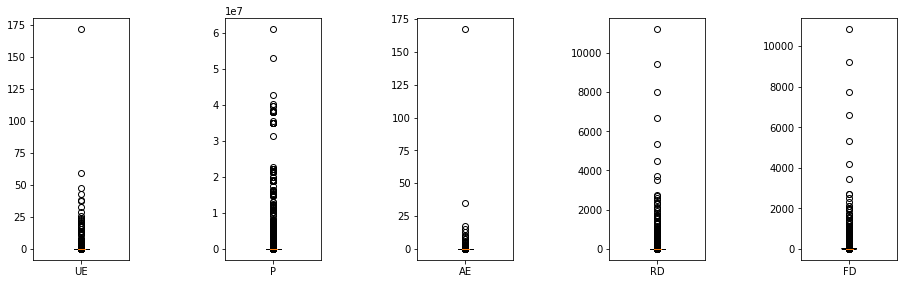

In [59]:
import matplotlib.pyplot as plt

def diagrama_caja(df):
    rs = list(df['RS'])
    p = list(df['P'])
    rsa = list(df['RSA'])
    pd = list(df['PD'])
    md = list(df['MD'])
    
    fig, [grs, gp, grsa, gpd, gmd] = plt.subplots(1,5)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0, right=2, hspace=1, wspace=1)
    
    plt.sca(grs)
    plt.boxplot([rs],labels=[short_names['RS']],notch=True)
    
    plt.sca(gp)
    plt.boxplot([p],labels=[short_names['P']],notch=True)
    
    plt.sca(grsa)
    plt.boxplot([rsa],labels=[short_names['RSA']],notch=True)
    
    plt.sca(gpd)
    plt.boxplot([pd],labels=[short_names['PD']],notch=True)
    
    plt.sca(gmd)
    plt.boxplot([md],labels=[short_names['MD']],notch=True)
    
    #plt.show()
    fig.savefig('dataset_stats.png', 
                format='png',
                bbox_inches='tight'
               )
    
diagrama_caja(dfc)

RS : (756, 15)
P : (873, 15)
RSA : (414, 15)
PD : (501, 15)
MD : (454, 15)


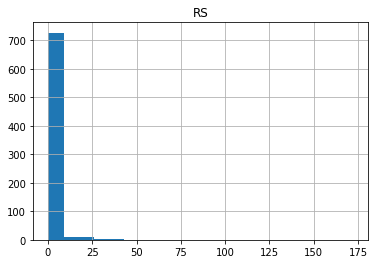

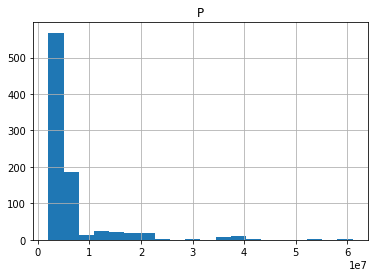

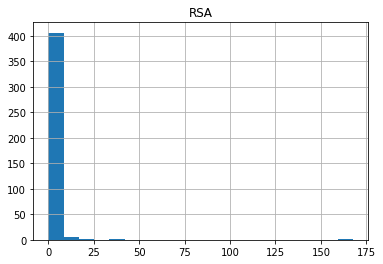

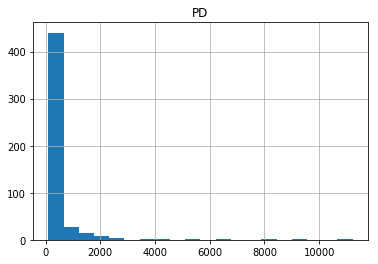

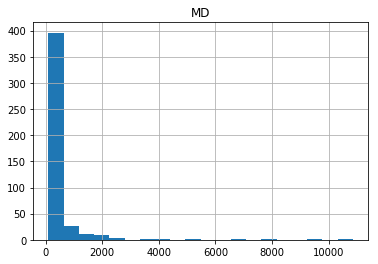

In [5]:
def histogram(df, column, t, bins=20):
    print(column, ':',df[df[column] >= t].shape)
    df[df[column] >= t].hist(column=column,bins=bins)

for k in umbrales:
    histogram(dfc, k, umbrales[k])

In [7]:
df = pd.read_json('tweets.json.gz', lines=True, compression='gzip')

from sklearn.utils.random import sample_without_replacement

def goods(df):
    d = dict()
    for k in umbrales:
        d[k] = df[df[k] >= umbrales[k]]              
    return d

# Dado un valor un los cortes Q1, Q2 y Q3 devuelve la clase en el rango [0,1,2]
# Los valores inferiores a Q2 son considerados 0, entre Q2 y Q3 son 1, y los superiores son 2
def calcClass(v,q1,q2,q3):
    if v < q2:
        return 0.0
    elif v < q3:
        return 1.0
    else:
        return 2.0
    

# Esto ya hace el undersampling cogiendo todos los N tweets exitosos y luego N tweets no exitosos
def subsets(df):
    d = dict()
    for k in umbrales:
        good = df[df[k] >= umbrales[k]]
        bad  = df[df[k] < umbrales[k]]
        
        bad_pos = sample_without_replacement(len(bad), len(good))
        bad_s = bad.iloc[bad_pos]
        
        d[k] = pd.concat([good, bad_s])
        q1 = d[k][k].describe()['25%']
        q2 = d[k][k].describe()['50%']
        q3 = d[k][k].describe()['75%']
        
        # Añade un campo 'class' con la clase en formato numérico 0..N
        d[k]['class'] = d[k][k].apply(lambda x: calcClass(x,q1,q2,q3))
        print(k,d[k]['class'].describe())
        print(k, len(d[k]))
              
    return d

goods = goods(df)
subsets = subsets(df)

for k in umbrales:
    print('Escribiendo', 'subsets/', k, '.csv')
    #aux = pd.read_csv('subsets/' + k + '.csv')
    subsets[k] = subsets[k][['QT', 'RP', k, 'characters', 'followers', 
                      'hashtags', 'hour', 'media', 'mentions','terms', 'verified','text','class']]
    print(subsets[k].dtypes)
    subsets[k].to_csv('subsets/' + k + '.csv', index=False)

RS count    1512.000000
mean        0.754630
std         0.833596
min         0.000000
25%         0.000000
50%         0.500000
75%         2.000000
max         2.000000
Name: class, dtype: float64
RS 1512
P count    1746.000000
mean        0.750286
std         0.829653
min         0.000000
25%         0.000000
50%         0.500000
75%         1.750000
max         2.000000
Name: class, dtype: float64
P 1746
RSA count    828.000000
mean       0.750000
std        0.829657
min        0.000000
25%        0.000000
50%        0.500000
75%        1.250000
max        2.000000
Name: class, dtype: float64
RSA 828
PD count    1002.000000
mean        0.750499
std         0.830022
min         0.000000
25%         0.000000
50%         0.500000
75%         1.750000
max         2.000000
Name: class, dtype: float64
PD 1002
MD count    908.000000
mean       0.751101
std        0.830609
min        0.000000
25%        0.000000
50%        0.500000
75%        2.000000
max        2.000000
Name: class, dtype

In [7]:
# Calculo de centroides
centroides = pd.DataFrame()

for k in goods:
    c = goods[k].describe()[['QT', 'RP', 'characters', 'followers',
       'hashtags', 'hour', 'media', 'mentions', 'terms', 'verified']].iloc[[1,2]].transpose()
    
    centroides[k + 'mean'] = c['mean']
    centroides[k + 'std'] = c['std']

centroides = centroides.round(2)
centroides.to_csv('centroides.csv')
centroides

#for k in 
#goods['RS'].columns#

,RSmean,RSstd,Pmean,Pstd,RSAmean,RSAstd,PDmean,PDstd,MDmean,MDstd
QT,0.10,0.30,0.01,0.12,0.09,0.28,0.11,0.31,0.11,0.32
RP,0.26,0.44,0.03,0.18,0.09,0.29,0.04,0.19,0.03,0.16
characters,108.56,41.09,90.30,27.09,110.42,40.44,109.86,39.55,110.21,39.70
followers,2812.28,16898.33,5711503.64,6819717.93,8276.75,26528.98,1084959.44,4173488.35,1064054.39,4179700.28
hashtags,0.90,1.71,0.36,0.73,0.91,1.67,0.46,0.91,0.45,0.91
hour,14.31,4.78,13.81,4.47,14.23,5.07,13.88,4.40,13.87,4.36
media,0.41,0.64,0.56,0.52,0.57,0.63,0.40,0.53,0.39,0.53
mentions,0.75,2.08,0.10,0.33,0.36,0.93,0.25,0.62,0.26,0.63
terms,17.27,7.33,14.02,4.70,17.63,7.27,17.68,6.77,17.78,6.79
verified,0.03,0.16,0.96,0.20,0.07,0.26,0.51,0.50,0.50,0.50


In [10]:
from sklearn.manifold import TSNE

tsne = dict()
for k in umbrales:
    X = subsets[k][['QT', 'RP', 'characters', 'followers','hashtags', 'hour', 'media', 'mentions', 'terms', 'verified']]
    print(k, X.shape)
    minX = TSNE(n_components=2, init='pca').fit_transform(X)
    print(minX.shape)
    tsne[k] = minX

RS (1512, 10)
(1512, 2)
P (1746, 10)
(1746, 2)
RSA (828, 10)
(828, 2)
PD (1002, 10)
(1002, 2)
MD (908, 10)
(908, 2)


In [12]:
import pickle
with open('tsne_dict.pkl', 'wb') as output:
    pickle.dump(tsne, output, pickle.HIGHEST_PROTOCOL)

In [6]:
def draw_tsne(tsne, subsets):
    fig, [[grs, grs2], [gp, gp2], [grsa, grsa2], [gpd, gpd2], [gmd, gmd2]] = plt.subplots(5,2)
    figs = {'RS': (grs,grs2), 'P':(gp,gp2), 'RSA':(grsa,grsa2), 'PD':(gpd,gpd2), 'MD':(gmd,gmd2)}
    plt.subplots_adjust(top=5, bottom=0, left=0, right=2, hspace=0.1, wspace=0.1)
    
    for k in figs:
        half = int(len(tsne[k])/2)
        
        fig.sca(figs[k][0])
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(short_names[k] + ': successful tweets')
        plt.scatter(tsne[k][:half,0], tsne[k][:half,1],marker='.', color='k')
        fig.sca(figs[k][1])
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title(short_names[k] + ': unsuccessful tweets')
        plt.scatter(tsne[k][half:,0], tsne[k][half:,1],marker='.', color='k')
        #plt.scatter(tsne[k][half:,0], tsne[k][half:,1],marker='o',c='g')
        #plt.scatter(tsne['RS'][:,0], tsne['RS'][:,1],marker='o',c='g')
    fig.savefig('dataset_comp.png', 
                format='png',
                dpi=300,
                bbox_inches='tight'
               )
    
#draw_tsne(tsne, subsets)

Cargando subsets/ RS .csv
Cargando subsets/ P .csv
Cargando subsets/ RSA .csv
Cargando subsets/ PD .csv
Cargando subsets/ MD .csv


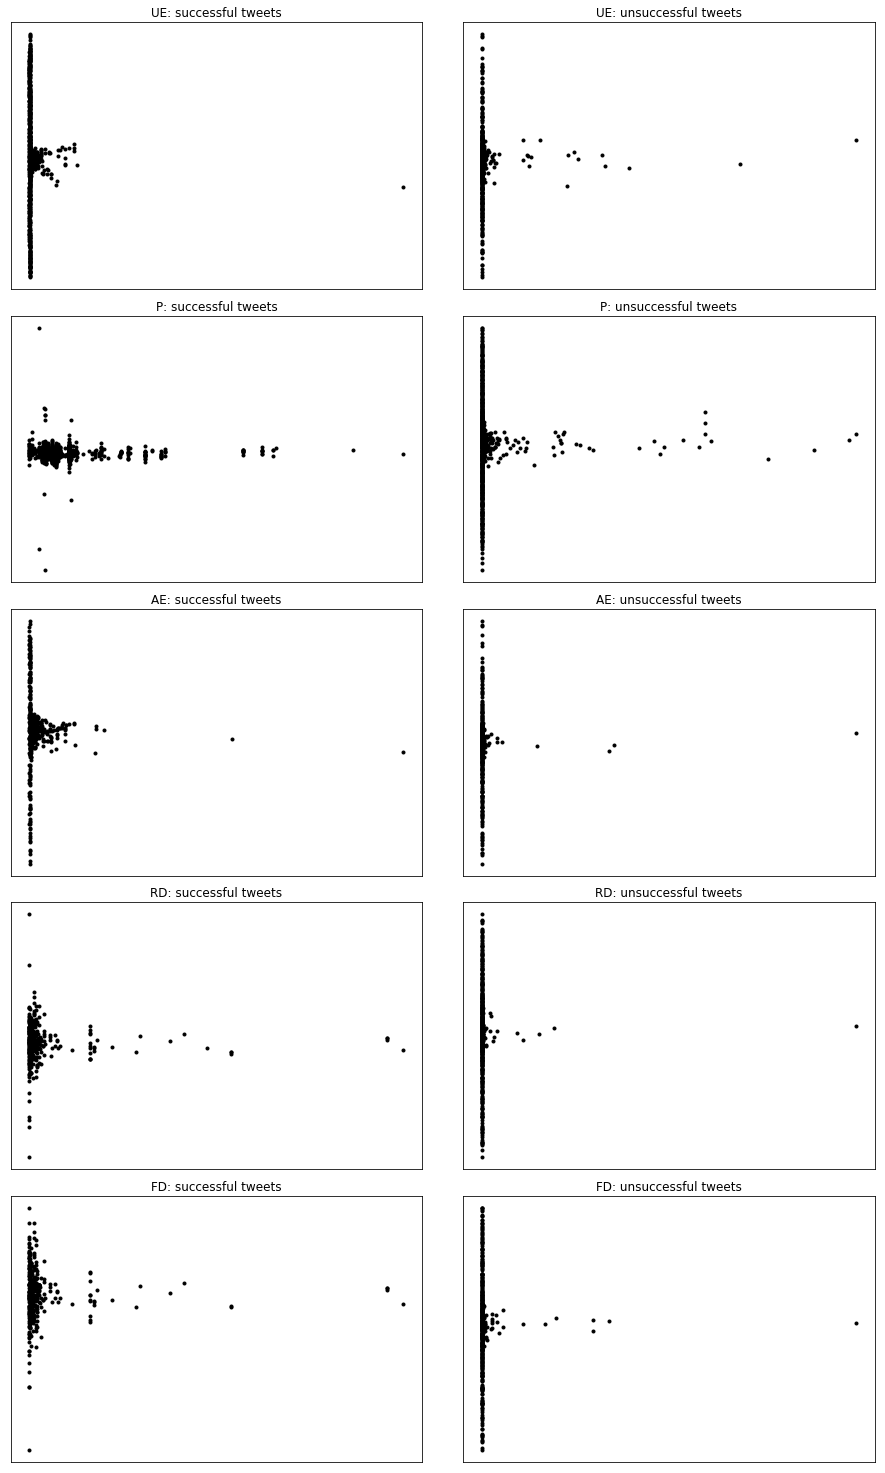

In [9]:
import pickle
import matplotlib.pyplot as plt

subsets_loaded = dict()
for k in umbrales:
    
    print('Cargando', 'subsets/', k, '.csv')
    subsets_loaded[k] = pd.read_csv('subsets/' + k + '.csv')
    
with open('tsne_dict.pkl', 'rb') as input:
    tsne_loaded = pickle.load(input)
    
draw_tsne(tsne_loaded, subsets_loaded) 

# Regresión con Spark

In [3]:
# Carga los subconjuntos y los divide en (train, test) en el diccionario subsets_spark
ratio = 0.7
subsets_spark = dict()

for k in umbrales:
    aux = spark.read.csv('subsets/' + k + '.csv', header=True, inferSchema=True)
    #aux.printSchema()
    good = aux.filter(aux[k] >= umbrales[k])
    bad = aux.filter(aux[k] < umbrales[k])
    print('Cargando subsets/' + k + '.csv --> Total:', aux.count(), 'Good:', good.count(), 'Bad:', bad.count())
    good_train, good_test = good.randomSplit([ratio, 1-ratio])
    bad_train, bad_test   = bad.randomSplit([ratio, 1-ratio])
    print('Good split:', good_train.count(), good_test.count(), '-->', good_train.count() + good_test.count())
    print('Bad split: ', bad_train.count(), bad_test.count(), '-->', bad_train.count()+ bad_test.count())
    subsets_spark[k] = (good_train.union(bad_train), good_test.union(bad_test))
    print(k, subsets_spark[k][0].count(), subsets_spark[k][1].count(),'-->', subsets_spark[k][0].count()+ subsets_spark[k][1].count(), '\n')

Cargando subsets/RS.csv --> Total: 1512 Good: 756 Bad: 756
Good split: 523 233 --> 756
Bad split:  510 246 --> 756
RS 1033 479 --> 1512 

Cargando subsets/P.csv --> Total: 1746 Good: 873 Bad: 873
Good split: 621 252 --> 873
Bad split:  614 259 --> 873
P 1235 511 --> 1746 

Cargando subsets/RSA.csv --> Total: 828 Good: 414 Bad: 414
Good split: 283 131 --> 414
Bad split:  290 124 --> 414
RSA 573 255 --> 828 

Cargando subsets/PD.csv --> Total: 1002 Good: 501 Bad: 501
Good split: 347 154 --> 501
Bad split:  346 155 --> 501
PD 693 309 --> 1002 

Cargando subsets/MD.csv --> Total: 908 Good: 454 Bad: 454
Good split: 297 157 --> 454
Bad split:  321 133 --> 454
MD 618 290 --> 908 



In [40]:
# Entrenamiento y validación usando 'RandomForestRegressor'

from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor


# Dado un conjunto de entrenamiento, uno de test, la etiqueta de clase y el número de iteraciones para CV
# encuentra el mejor modelo usando MAE en la CV y devuelve las métricas del modelo generado frente a 'test'
# Devuelve una lista [MSE, RMSE, R^2, MAE]
def train_test_randomforest(train, test, label, k=5):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features')
    #sca = MinMaxScaler(inputCol='features_raw', outputCol='features')
    # Es escalado no es necesario para Random Forests
    reg = RandomForestRegressor(featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[ohe, vec, #sca, 
                                reg])
    
    paramGrid = (
        ParamGridBuilder().addGrid(reg.featureSubsetStrategy, ['auto', 'all', 'onethird', 'sqrt', 'log2'])
            #addGrid(lr.regParam, [0.1, 0.01]) \
            .build()
                )

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol=label, metricName="mae"),
                          numFolds=k)  # use 3+ folds in practice
    
    model = crossval.fit(train)
    prediction = model.transform(test)
    
    #a, _ = prediction.randomSplit([0.2, 0.8])
    #prediction.select(label, 'Prediction').sample(False, 0.05).limit(20).show()
    
    evaluator = RegressionEvaluator(labelCol=label)
    ret = dict()
    ret['MSE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mse"})
    ret['RMSE'] = evaluator.evaluate(prediction, {evaluator.metricName: "rmse"})
    ret['R2']   = evaluator.evaluate(prediction, {evaluator.metricName: "r2"})
    ret['MAE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mae"})
    return ret

In [41]:
# Entrenamiento y validación usando 'GBTRegressor'

from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import GBTRegressor


# Dado un conjunto de entrenamiento, uno de test, la etiqueta de clase y el número de iteraciones para CV
# encuentra el mejor modelo usando MAE en la CV y devuelve las métricas del modelo generado frente a 'test'
# Devuelve una lista [MSE, RMSE, R^2, MAE]
def train_test_GBTRegressor(train, test, label, k=5):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features')
    #sca = MinMaxScaler(inputCol='features_raw', outputCol='features')
    # Es escalado no es necesario para Random Forests, pero no sé si para estos...
    reg = GBTRegressor(featuresCol='features', labelCol=label, lossType='absolute')
    pipeline = Pipeline(stages=[ohe, vec, #sca, 
                                reg])
    
    paramGrid = (
        ParamGridBuilder().addGrid(reg.minInstancesPerNode, [1,3,5,10,20])
            .addGrid(reg.lossType, ['absolute','squared'])
            .build()
                )

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol=label, metricName="mae"),
                          numFolds=k)  # use 3+ folds in practice
    
    model = crossval.fit(train)
    prediction = model.transform(test)
    
    #a, _ = prediction.randomSplit([0.2, 0.8])
    #prediction.select(label, 'Prediction').sample(False, 0.05).limit(20).show()
    
    evaluator = RegressionEvaluator(labelCol=label)
    ret = dict()
    ret['MSE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mse"})
    ret['RMSE'] = evaluator.evaluate(prediction, {evaluator.metricName: "rmse"})
    ret['R2']   = evaluator.evaluate(prediction, {evaluator.metricName: "r2"})
    ret['MAE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mae"})
    return ret

In [21]:
# Entrenamiento y validación usando 'LinearRegression'

from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression


# Dado un conjunto de entrenamiento, uno de test, la etiqueta de clase y el número de iteraciones para CV
# encuentra el mejor modelo usando MAE en la CV y devuelve las métricas del modelo generado frente a 'test'
# Devuelve una lista [MSE, RMSE, R^2, MAE]
def train_test_linear(train, test, label, k=5, verbose=False):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features')
    #sca = MinMaxScaler(inputCol='features_raw', outputCol='features')
    # Creo que el escalado no afecta a la regresión lineal
    reg = LinearRegression(featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[ohe, vec, #sca, 
                                reg])
    
    paramGrid = (
        ParamGridBuilder()
            .addGrid(reg.standardization, [True, False])
            .addGrid(reg.regParam, [0.1, 0.01, 1.0, 10.0])
            .addGrid(reg.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
                )

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol=label, metricName="mae"),
                          numFolds=k)  # use 3+ folds in practice
    
    model = crossval.fit(train)
    if verbose:
        print(model.bestModel.stages[0].categorySizes)
        print('Coeficientes:', model.bestModel.stages[2].coefficients)
        print('Intercept:', model.bestModel.stages[2].intercept)
    prediction = model.transform(test)
    
    
    #a, _ = prediction.randomSplit([0.2, 0.8])
    #prediction.select(label, 'Prediction').sample(False, 0.05).limit(20).show()
    
    evaluator = RegressionEvaluator(labelCol=label)
    ret = dict()
    ret['MSE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mse"})
    ret['RMSE'] = evaluator.evaluate(prediction, {evaluator.metricName: "rmse"})
    ret['R2']   = evaluator.evaluate(prediction, {evaluator.metricName: "r2"})
    ret['MAE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mae"})
    return ret

In [43]:
print(train_test_randomforest(subsets_spark['RS'][0], subsets_spark['RS'][1], 'RS', k=2))
print('********************\n\n\n')
print(train_test_GBTRegressor(subsets_spark['RS'][0], subsets_spark['RS'][1], 'RS', k=2))
print('********************\n\n\n')
print(train_test_linear(subsets_spark['RS'][0], subsets_spark['RS'][1], 'RS', k=2))

{'MSE': 28.137325322164045, 'RMSE': 5.304462774133121, 'R2': -0.6446327923067328, 'MAE': 1.6005631819877415}
********************



{'MSE': 22.13509392403744, 'RMSE': 4.704794780225535, 'R2': -0.2938010600313039, 'MAE': 1.3348349599678269}
********************



{'MSE': 17.143202290202844, 'RMSE': 4.140435036346162, 'R2': -0.002023906991847957, 'MAE': 1.3940066045977142}


In [46]:
# Crear y evaluar los modelos con RF, GRF y LR para cada métrica, y almacenarlo en un diccionario
def evalua(subsets, k):
    models = {'RF':train_test_randomforest, 'GRF':train_test_GBTRegressor, 'LR':train_test_linear}
    d = { 'RS':{}, 'P':{}, 'RSA':{}, 'PD':{}, 'MD':{} }
    for metric in umbrales:
        for technique in models:
            print('Evaluando', metric,'con',technique)
            d[metric][technique] = models[technique](subsets[metric][0], subsets[metric][1], metric, k)

    return d    

In [47]:
resultados = evalua(subsets_spark, 10)

Evaluando RS con RF
Evaluando RS con GRF
Evaluando RS con LR
Evaluando P con RF
Evaluando P con GRF
Evaluando P con LR
Evaluando RSA con RF
Evaluando RSA con GRF
Evaluando RSA con LR
Evaluando PD con RF
Evaluando PD con GRF
Evaluando PD con LR
Evaluando MD con RF
Evaluando MD con GRF
Evaluando MD con LR


In [48]:
import pickle
with open('resultados_dict.pkl', 'wb') as output:
    pickle.dump(resultados, output, pickle.HIGHEST_PROTOCOL)
    
resultados

{'MD': {'GRF': {'MAE': 249.59608675620768,
   'MSE': 660601.347844962,
   'R2': 0.007913827951718133,
   'RMSE': 812.7738602126436},
  'LR': {'MAE': 271.73170603567485,
   'MSE': 632141.1534731721,
   'R2': 0.050655135371341586,
   'RMSE': 795.073049142764},
  'RF': {'MAE': 245.4715617148575,
   'MSE': 598765.4739103721,
   'R2': 0.10077848175110005,
   'RMSE': 773.7993757495364}},
 'P': {'GRF': {'MAE': 801817.6907532105,
   'MSE': 7674327938692.923,
   'R2': 0.7934977064451584,
   'RMSE': 2770257.738675758},
  'LR': {'MAE': 463713.76853996236,
   'MSE': 2019143887796.096,
   'R2': 0.945668487562945,
   'RMSE': 1420965.8292147971},
  'RF': {'MAE': 806302.9128900442,
   'MSE': 8029275451503.369,
   'R2': 0.7839467104397118,
   'RMSE': 2833597.6163709923}},
 'PD': {'GRF': {'MAE': 210.81813609608895,
   'MSE': 182549.26612564965,
   'R2': -0.39827792857250843,
   'RMSE': 427.2578450135815},
  'LR': {'MAE': 226.31280653837422,
   'MSE': 138754.12535178254,
   'R2': -0.06281901371346965,
  

In [8]:
# Crear DataFrame de Pandas y volcar a CSV
import pickle 
with open('resultados_dict.pkl', 'rb') as input:
    resultados = pickle.load(input)
    
dframe = {'metrica': ['MSE', 'RMSE', 'R2','MAE']}
for metric in umbrales:
        for technique in resultados[metric]:
            dframe[metric+technique] = [resultados[metric][technique]['MSE'],resultados[metric][technique]['RMSE'],
                                       resultados[metric][technique]['R2'], resultados[metric][technique]['MAE']]
df = pd.DataFrame.from_dict(dframe)
df.round(2).to_csv('results.csv')

In [22]:
train_test_linear(subsets_spark['P'][0], subsets_spark['P'][1], 'P', k=2, verbose=True)

[24]
Coeficientes: [3298.7787235422306,0.9847727604000812,78753.89988081946,-89716.50023135888,8314.36844557181,-40819.33626924154,-199404.49849231285,-242023.3666448456,3038.7341615206315,-1108011.307439412,-1224151.4717856352,-1132709.7434509003,-1224834.092292791,-1090143.154812098,-1220095.446495487,-944259.5252929431,-947310.6738852365,-863308.9069181661,-818497.2911828576,-757324.3932852069,-1000227.2704346977,-901543.7997010972,-1014137.7670123758,-636272.5105843542,-768386.8185219995,-686075.8652384295,-959864.9139973979,-947728.5430857852,-1043198.7449536648,-1046461.6266484429,-1125342.102414697,-1140506.842617705]
Intercept: 878700.9419889046


{'MAE': 460457.42222115723,
 'MSE': 1536844018481.677,
 'R2': 0.9508423135423931,
 'RMSE': 1239695.131264811}

In [11]:
## Baselines
from pyspark.ml.feature import NGram
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
import pickle


def baseline_regression(label, k, n = 1, verbose=False):
    tok = Tokenizer(inputCol="text", outputCol="words")
    stopENG = StopWordsRemover.loadDefaultStopWords('english')
    stopSPA = StopWordsRemover.loadDefaultStopWords('spanish')
    sto = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=stopENG+stopSPA)
    ngram = NGram(n=n, inputCol="filtered", outputCol="ngrams")
    
    cv = CountVectorizer(inputCol="ngrams", outputCol="features", minDF=1)    
    tf = HashingTF(inputCol="ngrams", outputCol="rawFeatures")
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    
    #reg = RandomForestRegressor(featuresCol='features', labelCol=label)
    reg = LinearRegression(featuresCol='features', labelCol=label)
        
    pipeline = Pipeline(stages=[tok,sto,ngram,cv,reg])
    #pipeline = Pipeline(stages=[tok,sto,ngram,tf,idf,reg])
    
    paramGrid = (
        ParamGridBuilder()
            .addGrid(reg.standardization, [True, False])
            .addGrid(reg.regParam, [0.1, 0.01, 1.0, 10.0])
            .addGrid(reg.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
    )

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol=label, metricName="mae"),
                          numFolds=k)  # use 3+ folds in practice
    
    return crossval #########


n_folds = 3
baselines_reg = {k:{} for k in umbrales}
for k in umbrales:
    for n in [1,2,3]:
        print(k, n)
        pipeline = baseline_regression(k,n_folds,n)
        model = pipeline.fit(subsets_spark[k][0])
        prediction = model.transform(subsets_spark[k][1])
        evaluator = RegressionEvaluator(labelCol=k)
        ret = dict()
        ret['MSE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mse"})
        ret['RMSE'] = evaluator.evaluate(prediction, {evaluator.metricName: "rmse"})
        ret['R2']   = evaluator.evaluate(prediction, {evaluator.metricName: "r2"})
        ret['MAE']  = evaluator.evaluate(prediction, {evaluator.metricName: "mae"})
        baselines_reg[k][n] = ret

        
with open('baselines_reg_dict.pkl', 'wb') as output:
    pickle.dump(baselines_reg, output, pickle.HIGHEST_PROTOCOL)
    
baselines_reg

RS 1
RS 2
RS 3
P 1
P 2
P 3
RSA 1
RSA 2
RSA 3
PD 1
PD 2
PD 3
MD 1
MD 2
MD 3


{'RS': {1: {'MSE': 78.94833760093316,
   'RMSE': 8.885287705017388,
   'R2': -0.003413290895510679,
   'MAE': 1.3428070192362995},
  2: {'MSE': 79.26853715994486,
   'RMSE': 8.903287997135937,
   'R2': -0.0074829458498086865,
   'MAE': 1.3412663305958625},
  3: {'MSE': 79.8184619246518,
   'RMSE': 8.934117859344134,
   'R2': -0.014472349739333978,
   'MAE': 1.3523949781794986}},
 'P': {1: {'MSE': 28660318709977.645,
   'RMSE': 5353533.292133116,
   'R2': 0.08510929667707445,
   'MAE': 2617151.842799052},
  2: {'MSE': 33832425332267.28,
   'RMSE': 5816564.736360052,
   'R2': -0.07999397077823067,
   'MAE': 2544885.424964668},
  3: {'MSE': 37367192700947.9,
   'RMSE': 6112871.068568999,
   'R2': -0.19283032255575994,
   'MAE': 2735584.0289076813}},
 'RSA': {1: {'MSE': 110.27319820763759,
   'RMSE': 10.50110461845027,
   'R2': -0.006745987661369135,
   'MAE': 0.9430014702530698},
  2: {'MSE': 110.17250936282115,
   'RMSE': 10.496309321033806,
   'R2': -0.005826742621152237,
   'MAE': 0.88

In [49]:
def bestBaseline_reg(dicc, metric):
    l = [(dicc[metric][n]['MAE'], n) for n in dicc[metric].keys()]
    l.sort(reverse=False)
    return {'ngram': l[0][1], 'values': dicc[metric][l[0][1]]}

#[baselines['RS'][n]['acc'] for n in [1,2,3]]
for k in umbrales:
    print(k, bestBaseline_reg(baselines_reg, 'RS')['ngram'])

RS 2
P 2
RSA 2
PD 2
MD 2


In [48]:
import csv

with open('baselines_reg_dict.pkl', 'rb') as input:
    b = pickle.load(input)
    
with open('resultados_dict.pkl', 'rb') as input:
    c = pickle.load(input)
    
def scinum(n, kk=None):
    a = '%.3E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'e' + a.split('E')[1][1:]

def generaCSVs_reg(baselines, reg):
    for metric in umbrales:
        base = bestBaseline_reg(baselines, metric)
        
        # RF':train_test_randomforest, 'GRF':train_test_GBTRegressor, 'LR':tr
        
        if metric == 'P':
            l = [['metric', 'baseline', 'RF', 'GRF', 'LR']]
            l.append(['MSE',  scinum(base['values']['MSE'],2),   scinum(reg[metric]['RF']['MSE'],2),  scinum(reg[metric]['GRF']['MSE'],2),  scinum(reg[metric]['LR']['MSE'],2)])
            l.append(['RMSE', scinum(base['values']['RMSE'],2), scinum(reg[metric]['RF']['RMSE'],2), scinum(reg[metric]['GRF']['RMSE'],2), scinum(reg[metric]['LR']['RMSE'],2)])
            l.append(['R2',   round(base['values']['R2'],2),   round(reg[metric]['RF']['R2'],2),   round(reg[metric]['GRF']['R2'],2),   scinum(reg[metric]['LR']['R2'],2)])
            l.append(['MAE',  scinum(base['values']['MAE'],2),    scinum(reg[metric]['RF']['MAE'],2), scinum(reg[metric]['GRF']['MAE'],2),  scinum(reg[metric]['LR']['MAE'],2)])
            #a = '%.3E' % n
            #return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]
        else:
            l = [['metric', 'baseline', 'RF', 'GRF', 'LR']]
            l.append(['MSE',  round(base['values']['MSE'],2),   round(reg[metric]['RF']['MSE'],2),  round(reg[metric]['GRF']['MSE'],2),  round(reg[metric]['LR']['MSE'],2)])
            l.append(['RMSE', round(base['values']['RMSE'],2), round(reg[metric]['RF']['RMSE'],2), round(reg[metric]['GRF']['RMSE'],2), round(reg[metric]['LR']['RMSE'],2)])
            l.append(['R2',   round(base['values']['R2'],2),   round(reg[metric]['RF']['R2'],2),   round(reg[metric]['GRF']['R2'],2),   round(reg[metric]['LR']['R2'],2)])
            l.append(['MAE',  round(base['values']['MAE'],2),    round(reg[metric]['RF']['MAE'],2), round(reg[metric]['GRF']['MAE'],2),  round(reg[metric]['LR']['MAE'],2)])
        
        print(l)
        with open("reg/" + metric + ".csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(l)
    
generaCSVs_reg(b, c)

[['metric', 'baseline', 'RF', 'GRF', 'LR'], ['MSE', 79.27, 20.42, 18.31, 17.14], ['RMSE', 8.9, 4.52, 4.28, 4.14], ['R2', -0.01, -0.19, -0.07, -0.0], ['MAE', 1.34, 1.39, 1.26, 1.39]]
[['metric', 'baseline', 'RF', 'GRF', 'LR'], ['MSE', '3.383e13', '8.029e12', '7.674e12', '2.019e12'], ['RMSE', '5.817e06', '2.834e06', '2.77e06', '1.421e06'], ['R2', -0.08, 0.78, 0.79, '9.457e01'], ['MAE', '2.545e06', '8.063e05', '8.018e05', '4.637e05']]
[['metric', 'baseline', 'RF', 'GRF', 'LR'], ['MSE', 110.17, 12.64, 6.69, 5.96], ['RMSE', 10.5, 3.56, 2.59, 2.44], ['R2', -0.01, -1.17, -0.15, -0.03], ['MAE', 0.89, 0.95, 0.57, 0.73]]
[['metric', 'baseline', 'RF', 'GRF', 'LR'], ['MSE', 877344.29, 135236.63, 182549.27, 138754.13], ['RMSE', 936.67, 367.75, 427.26, 372.5], ['R2', -0.13, -0.04, -0.4, -0.06], ['MAE', 252.35, 202.68, 210.82, 226.31]]
[['metric', 'baseline', 'RF', 'GRF', 'LR'], ['MSE', 259043.79, 598765.47, 660601.35, 632141.15], ['RMSE', 508.96, 773.8, 812.77, 795.07], ['R2', -0.09, 0.1, 0.01, 0.05

# Clasificación con Spark

In [50]:
# Carga los subconjuntos y los divide en (train, test) en el diccionario subsets_spark
ratio = 0.7
subsets_clasificacion_spark = dict()

for k in umbrales:
    aux = spark.read.csv('subsets/' + k + '.csv', header=True, inferSchema=True)
    
    #aux.printSchema()
    # obtiene los distintos valores de class
    valores = aux.select("class").rdd.map(lambda r: r[0]).collect()
    valores = list(set(valores))
    print(k, valores)

    trozos = {}
    for c in valores:
        trozos[c] = aux.filter(aux['class'] == c)
        print(c,trozos[c].count())
    
    print('Cargando subsets/' + k + '.csv --> Total:', aux.count())
    for c in valores:
        trozos[c] = trozos[c].randomSplit([ratio, 1-ratio])
        print(c, trozos[c][0].count(), trozos[c][1].count())
        
    train = trozos[valores[0]][0]
    test = trozos[valores[0]][1]
    for c in valores[1:]:
        train = train.union(trozos[c][0])
        test = test.union(trozos[c][1])
    #print('train', train.count(), 'test', test.count(), test.count() + train.count())     
    
    subsets_clasificacion_spark[k] = (train, test)
    print(k, subsets_clasificacion_spark[k][0].count(), subsets_clasificacion_spark[k][1].count(),'-->', subsets_clasificacion_spark[k][0].count()+ subsets_clasificacion_spark[k][1].count(), '\n')
    
    #good_train, good_test = good.randomSplit([ratio, 1-ratio])
    #bad_train, bad_test   = bad.randomSplit([ratio, 1-ratio])
    
    #print('Good split:', good_train.count(), good_test.count(), '-->', good_train.count() + good_test.count())
    #print('Bad split: ', bad_train.count(), bad_test.count(), '-->', bad_train.count()+ bad_test.count())
    #subsets_spark[k] = (good_train.union(bad_train), good_test.union(bad_test))
    #print(k, subsets_spark[k][0].count(), subsets_spark[k][1].count(),'-->', subsets_spark[k][0].count()+ subsets_spark[k][1].count(), '\n')

RS [0.0, 1.0, 2.0]
0.0 756
1.0 371
2.0 385
Cargando subsets/RS.csv --> Total: 1512
0.0 531 225
1.0 261 110
2.0 261 124
RS 1053 459 --> 1512 

P [0.0, 1.0, 2.0]
0.0 873
1.0 436
2.0 437
Cargando subsets/P.csv --> Total: 1746
0.0 622 251
1.0 312 124
2.0 313 124
P 1247 499 --> 1746 

RSA [0.0, 1.0, 2.0]
0.0 414
1.0 207
2.0 207
Cargando subsets/RSA.csv --> Total: 828
0.0 298 116
1.0 149 58
2.0 147 60
RSA 594 234 --> 828 

PD [0.0, 1.0, 2.0]
0.0 501
1.0 250
2.0 251
Cargando subsets/PD.csv --> Total: 1002
0.0 343 158
1.0 182 68
2.0 173 78
PD 698 304 --> 1002 

MD [0.0, 1.0, 2.0]
0.0 454
1.0 226
2.0 228
Cargando subsets/MD.csv --> Total: 908
0.0 314 140
1.0 167 59
2.0 148 80
MD 629 279 --> 908 



In [29]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas

def confusionMatrix(df, className, predictionName='prediction'):
    predictionAndLabels = df.select(predictionName, className).rdd
    metrics = MulticlassMetrics(predictionAndLabels)
    data = metrics.confusionMatrix().toArray()
    data = data.astype(int)
    return pd.DataFrame(data=data[0:,0:],    # values
                 index=['L', 'M', 'H'],    # clase real -> fila
                 columns=['L','M', 'H'])   # prediccion -> columna
    

In [22]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# rfc() devuelve un Pipeline de clasificación con RandomForests configurado para optimizar hiperparámetros
# usando cross-validations
def rfc(label, k = 3, verbose=False):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features')
    # sca = MinMaxScaler(inputCol='features_raw', outputCol='features')
    # Creo que el escalado no afecta a la regresión lineal
    clf = RandomForestClassifier(featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[ohe, vec, clf])
    
    paramGrid = (
        ParamGridBuilder()
            #.addGrid(clf.numTrees, [10, 20, 30, 50])
            .addGrid(clf.impurity, ['gini','entropy'])
            #.addGrid(clf.featureSubsetStrategy, ['auto', 'all', 'onethird', 'sqrt', 'log2'])
            .build()
                )
    
    evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy") 

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=k)  # use 3+ folds in practice
    
    return crossval


from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression

# lreg() devuelve un Pipeline de clasificación con LogisticRegression configurado para optimizar hiperparámetros
# usando cross-validations
def lreg(label, k = 3, verbose=False):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features_raw')
    sca = StandardScaler(inputCol='features_raw', outputCol='features')
    # Recommended in Elements of Statistical Learning when using regularization
    clf = LogisticRegression(featuresCol='features', labelCol=label, family='multinomial')
    pipeline = Pipeline(stages=[ohe, vec, sca, clf])
    
    paramGrid = (
        ParamGridBuilder()
            .addGrid(clf.regParam, [0.1, 0.5, 1.0])
            .addGrid(clf.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
                )
    
    evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy") 

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=k)  # use 3+ folds in practice
    
    return crossval


from pyspark.ml.classification import MultilayerPerceptronClassifier

# mlp() devuelve un Pipeline de clasificación con MultilayerPerceptronClassifier configurado 
# para optimizar hiperparámetros mediante cross-validation
def mlp(label, k = 3, verbose=False):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features')
    #sca = StandardScaler(inputCol='features_raw', outputCol='features')
    # Recommended in Elements of Statistical Learning when using regularization
    clf = MultilayerPerceptronClassifier(maxIter=100, blockSize=1, seed=123,featuresCol='features', labelCol=label)
    #clf = MultilayerPerceptronClassifier(featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[ohe, vec, clf])
    
    paramGrid = (
        ParamGridBuilder()
            .addGrid(clf.layers, [[32, 3], [32,16,3], [32, 5, 5, 5, 3], [32, 8, 8, 8, 3]])
            .addGrid(clf.stepSize, [0.03, 0.1])
            .build()
                )
    
    evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy") 

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=k)  # use 3+ folds in practice
    
    return crossval


from pyspark.ml.classification import NaiveBayes

# nb() devuelve un Pipeline de clasificación con NaiveBayes configurado 
# para optimizar hiperparámetros mediante cross-validation
def nb(label, k = 3, verbose=False):
    ohe = OneHotEncoderEstimator(inputCols=['hour'], outputCols=['hour_OHE'])
    vec = VectorAssembler(inputCols=['characters', 'followers', 'verified', 'media', 'hashtags', 'mentions', 'RP',
                                 'QT', 'terms', 'hour_OHE'], outputCol='features')
    #sca = StandardScaler(inputCol='features_raw', outputCol='features')
    # Recommended in Elements of Statistical Learning when using regularization
    clf = NaiveBayes(modelType="multinomial", labelCol=label)
    #clf = MultilayerPerceptronClassifier(featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[ohe, vec, clf])
    
    paramGrid = (
        ParamGridBuilder()
            .addGrid(clf.smoothing, [0.0, 1.0, 2.0])
            .build()
                )
    
    evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy") 

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=k)  # use 3+ folds in practice
    
    return crossval


import pickle
def calculaClasificadores():
    cv_folds = 5
    resultados_clasificacion = {metric:{} for metric in umbrales}
    for metric in umbrales:
        for (name, method) in [('rfc',rfc), ('lreg',lreg), ('nb',nb)]:
            print(metric, name,method)
            results = {}
            pipeline = method('class', cv_folds)
            model = pipeline.fit(subsets_clasificacion_spark[metric][0])
            predictions = model.transform(subsets_clasificacion_spark[metric][1])
            evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy")
            results['acc'] = evaluator.evaluate(predictions)
            evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="f1")
            results['f1'] = evaluator.evaluate(predictions)
            results['mat'] = confusionMatrix(predictions,'class')
            #results['model'] = model
            resultados_clasificacion[metric][name] = results

    with open('classification_dict.pkl', 'wb') as output:
        pickle.dump(resultados_clasificacion, output, pickle.HIGHEST_PROTOCOL)
    return resultados_clasificacion
        
calculaClasificadores()

RS rfc <function rfc at 0x7f2c0c224378>
[[204.  11.   5.]
 [ 58.  25.  20.]
 [ 49.  14.  42.]]
[[204  11   5]
 [ 58  25  20]
 [ 49  14  42]]
RS lreg <function lreg at 0x7f2c0c224048>
[[196.   5.  19.]
 [ 64.  18.  21.]
 [ 67.  15.  23.]]
[[196   5  19]
 [ 64  18  21]
 [ 67  15  23]]
RS nb <function nb at 0x7f2c0c2240d0>
[[ 30.  38. 152.]
 [  7.  21.  75.]
 [  3.  13.  89.]]
[[ 30  38 152]
 [  7  21  75]
 [  3  13  89]]
P rfc <function rfc at 0x7f2c0c224378>
[[233.   4.   0.]
 [ 12. 126.   0.]
 [  6.  12. 104.]]
[[233   4   0]
 [ 12 126   0]
 [  6  12 104]]
P lreg <function lreg at 0x7f2c0c224048>
[[218.  19.   0.]
 [  5. 133.   0.]
 [  4.  28.  90.]]
[[218  19   0]
 [  5 133   0]
 [  4  28  90]]
P nb <function nb at 0x7f2c0c2240d0>
[[224.  13.   0.]
 [  5. 125.   8.]
 [  5.  16. 101.]]
[[224  13   0]
 [  5 125   8]
 [  5  16 101]]
RSA rfc <function rfc at 0x7f2c0c224378>
[[117.  11.   4.]
 [ 33.  20.   6.]
 [ 26.  19.  19.]]
[[117  11   4]
 [ 33  20   6]
 [ 26  19  19]]
RSA lreg <funct

{'RS': {'rfc': {'acc': 0.633177570093458,
   'f1': 0.5934082909088668,
   'mat':      L   M   H
   L  204  11   5
   M   58  25  20
   H   49  14  42},
  'lreg': {'acc': 0.5537383177570093,
   'f1': 0.49698092471344446,
   'mat':      L   M   H
   L  196   5  19
   M   64  18  21
   H   67  15  23},
  'nb': {'acc': 0.32710280373831774,
   'f1': 0.280101705739817,
   'mat':     L   M    H
   L  30  38  152
   M   7  21   75
   H   3  13   89}},
 'P': {'rfc': {'acc': 0.93158953722334,
   'f1': 0.9311846269843054,
   'mat':      L    M    H
   L  233    4    0
   M   12  126    0
   H    6   12  104},
  'lreg': {'acc': 0.8873239436619719,
   'f1': 0.8887668889066344,
   'mat':      L    M   H
   L  218   19   0
   M    5  133   0
   H    4   28  90},
  'nb': {'acc': 0.9054325955734407,
   'f1': 0.905958589955425,
   'mat':      L    M    H
   L  224   13    0
   M    5  125    8
   H    5   16  101}},
 'RSA': {'rfc': {'acc': 0.611764705882353,
   'f1': 0.580735796340831,
   'mat':      L 

In [26]:
## Baselines
from pyspark.ml.feature import NGram
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pickle


def baseline(label, k, n = 1, verbose=False):
    tok = Tokenizer(inputCol="text", outputCol="words")
    stopENG = StopWordsRemover.loadDefaultStopWords('english')
    stopSPA = StopWordsRemover.loadDefaultStopWords('spanish')
    sto = StopWordsRemover(inputCol="words", outputCol="filtered", stopWords=stopENG+stopSPA)
    ngram = NGram(n=n, inputCol="filtered", outputCol="ngrams")
    
    #cv = CountVectorizer(inputCol="ngrams", outputCol="features", minDF=1)    
    tf = HashingTF(inputCol="ngrams", outputCol="rawFeatures")
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    
    clf = nb = NaiveBayes(modelType="multinomial",featuresCol='features', labelCol=label)
    pipeline = Pipeline(stages=[tok,sto,ngram,tf,idf,clf])
    
    paramGrid = (
        ParamGridBuilder()
            .addGrid(clf.smoothing, [0.0, 1.0, 2.0])
            .build()
                )
    
    evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy") 

    crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=k)  # use 3+ folds in practice
    
    return crossval


baselines = {k:{} for k in umbrales}
for k in umbrales:
    for n in [1,2,3]:
        print(k, n)
        pipeline = baseline('class',5,n)
        model = pipeline.fit(subsets_clasificacion_spark[k][0])
        predictions = model.transform(subsets_clasificacion_spark[k][1])
        evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="accuracy")
        acc = evaluator.evaluate(predictions)
        evaluator = MulticlassClassificationEvaluator(labelCol='class', predictionCol="prediction", metricName="f1")
        f1 = evaluator.evaluate(predictions)
        mat = confusionMatrix(predictions,'class')
        baselines[k][n] = {'acc':acc, 'f1':f1, 'mat':mat}

        
with open('baselines_dict.pkl', 'wb') as output:
    pickle.dump(baselines, output, pickle.HIGHEST_PROTOCOL)

RS 1
[[220.   0.   0.]
 [102.   0.   1.]
 [105.   0.   0.]]
[[220   0   0]
 [102   0   1]
 [105   0   0]]
RS 2
[[220.   0.   0.]
 [103.   0.   0.]
 [105.   0.   0.]]
[[220   0   0]
 [103   0   0]
 [105   0   0]]
RS 3
[[220.   0.   0.]
 [103.   0.   0.]
 [105.   0.   0.]]
[[220   0   0]
 [103   0   0]
 [105   0   0]]
P 1
[[185.  27.  25.]
 [ 44.  68.  26.]
 [ 40.  13.  69.]]
[[185  27  25]
 [ 44  68  26]
 [ 40  13  69]]
P 2
[[235.   1.   1.]
 [136.   2.   0.]
 [106.   0.  16.]]
[[235   1   1]
 [136   2   0]
 [106   0  16]]
P 3
[[236.   1.   0.]
 [136.   2.   0.]
 [107.   0.  15.]]
[[236   1   0]
 [136   2   0]
 [107   0  15]]
RSA 1
[[90. 23. 19.]
 [29. 17. 13.]
 [28. 13. 23.]]
[[90 23 19]
 [29 17 13]
 [28 13 23]]
RSA 2
[[75. 15. 42.]
 [23.  6. 30.]
 [28.  7. 29.]]
[[75 15 42]
 [23  6 30]
 [28  7 29]]
RSA 3
[[132.   0.   0.]
 [ 59.   0.   0.]
 [ 64.   0.   0.]]
[[132   0   0]
 [ 59   0   0]
 [ 64   0   0]]
PD 1
[[162.   1.   0.]
 [ 69.   2.   0.]
 [ 81.   3.   0.]]
[[162   1   0]
 [ 69  

In [35]:
def bestBaseline_classif(dicc, metric):
    l = [(dicc[metric][n]['acc'], n) for n in dicc[metric].keys()]
    l.sort(reverse=True)
    print(l)
    return {'ngram': l[0][1], 'values': dicc[metric][l[0][1]]}

#[baselines['RS'][n]['acc'] for n in [1,2,3]]
bestBaseline_classif(baselines, 'PD')

[(0.5157232704402516, 2), (0.5157232704402516, 1), (0.5125786163522013, 3)]


{'ngram': 2,
 'values': {'acc': 0.5157232704402516,
  'f1': 0.3550684038534466,
  'mat':      L  M  H
  L  163  0  0
  M   71  0  0
  H   82  1  1}}

In [28]:
import csv

with open('baselines_dict.pkl', 'rb') as input:
    b = pickle.load(input)
    
with open('classification_dict.pkl', 'rb') as input:
    c = pickle.load(input)    
    

def generaCSVs_clasif(baselines, classif):
    for metric in umbrales:
        base = bestBaseline_classif(baselines, metric)
        
        base['values']['mat'].to_csv("classif/baseline_" + metric + "_confMatrix.csv")
        classif[metric]['rfc']['mat'].to_csv("classif/rfc_" + metric + "_confMatrix.csv")
        classif[metric]['lreg']['mat'].to_csv("classif/lreg_" + metric + "_confMatrix.csv")
        classif[metric]['nb']['mat'].to_csv("classif/nb_" + metric + "_confMatrix.csv")
        
        l = [['metric', 'baseline', 'RF', 'LogReg', 'NB']]
        l.append(['Accuracy', round(base['values']['acc'],2),  round(classif[metric]['rfc']['acc'],2),  round(classif[metric]['lreg']['acc'],2), round(classif[metric]['nb']['acc'],2)])
        l.append(['F-measure', round(base['values']['f1'],2), round(classif[metric]['rfc']['f1'],2), round(classif[metric]['lreg']['f1'],2), round(classif[metric]['nb']['f1'],2)])
        print(l)
        with open("classif/" + metric + ".csv", "w") as f:
            writer = csv.writer(f)
            writer.writerows(l)
    
generaCSVs_clasif(b, c)

[(0.514018691588785, 3), (0.514018691588785, 2), (0.514018691588785, 1)]
[['metric', 'baseline', 'RF', 'LogReg', 'NB'], ['Acc', 0.51, 0.63, 0.55, 0.33], ['F-measure', 0.35, 0.59, 0.5, 0.28]]
[(0.647887323943662, 1), (0.5090543259557344, 3), (0.5090543259557344, 2)]
[['metric', 'baseline', 'RF', 'LogReg', 'NB'], ['Acc', 0.65, 0.93, 0.89, 0.91], ['F-measure', 0.64, 0.93, 0.89, 0.91]]
[(0.5176470588235295, 3), (0.5098039215686274, 1), (0.43137254901960786, 2)]
[['metric', 'baseline', 'RF', 'LogReg', 'NB'], ['Acc', 0.52, 0.61, 0.58, 0.31], ['F-measure', 0.35, 0.58, 0.53, 0.25]]
[(0.5157232704402516, 2), (0.5157232704402516, 1), (0.5125786163522013, 3)]
[['metric', 'baseline', 'RF', 'LogReg', 'NB'], ['Acc', 0.52, 0.66, 0.61, 0.63], ['F-measure', 0.36, 0.65, 0.51, 0.57]]
[(0.5130111524163569, 3), (0.5130111524163569, 2), (0.5130111524163569, 1)]
[['metric', 'baseline', 'RF', 'LogReg', 'NB'], ['Acc', 0.51, 0.68, 0.57, 0.59], ['F-measure', 0.35, 0.68, 0.53, 0.54]]


In [82]:
df = pd.read_json('tweets.json.gz', lines=True, compression='gzip')
#print(df[df.P >= 11719747]['hour'].value_counts())
#df[df.P >= 11719747]['hour'].hist(bins=24).plot()
df.describe()
#a = 6.108598e+07
#a
df[['P','followers']].corr()
#df[df.P >= 11719747]['followers'].sort_values()#.hist(bins=1000).plot()

,P,followers
P,1.000000,0.976562
followers,0.976562,1.000000
